<a href="https://colab.research.google.com/github/nguyenhongquang4/Air-pollution-in-HaNoi/blob/main/Air_quality_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from joblib import Parallel, delayed
import random
np.random.seed(42)
random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AnyConv.com__concentration_data.csv")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/new_data.csv")
df.tail()

,CO,NO2,pm10,pm25,Temperature,Humidity,Wind speed,date,time,CO_AQI,NO2_AQI,pm10_AQI,pm25_AQI,AQI
7245,1330.0,40.8,52.1,26.3,20.0,0.66,2.56,11/26/2024,19:00,13,20,48,83,83
7246,1250.0,41.3,70.0,27.4,20.0,0.69,2.60,11/26/2024,20:00,12,21,58,85,85
7247,1110.0,42.3,56.3,33.7,20.0,0.69,2.41,11/26/2024,21:00,11,21,52,97,97
7248,1060.0,41.1,57.1,28.7,19.0,0.70,2.27,11/26/2024,22:00,11,21,52,88,88
7249,964.0,41.3,44.1,29.3,19.0,0.71,2.38,11/26/2024,23:00,10,21,41,89,89


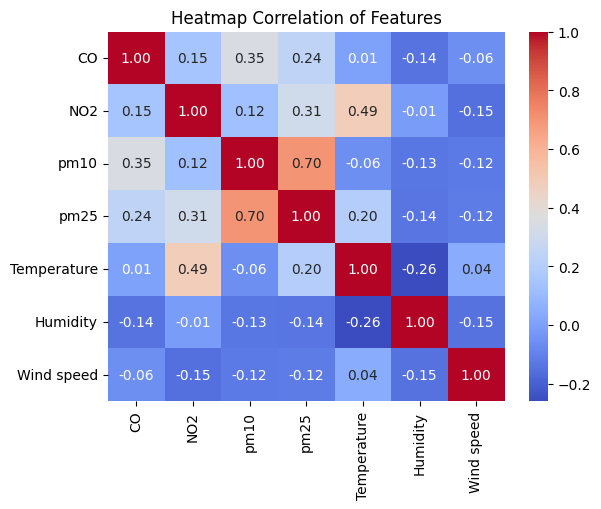

In [ ]:
selected_features = ['CO', 'NO2', 'pm10', 'pm25', 'Temperature', 'Humidity', 'Wind speed']
corr_matrix = df[selected_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Correlation of Features")
plt.show()

## **REGRESSION DECISION TREE**


In [ ]:
class Node():
  def __init__(self, best_feature=None, best_threshold=None, left=None, right=None, var=None, value=None):
    self.best_feature = best_feature
    self.best_threshold = best_threshold
    self.left = left
    self.right = right
    self.var = var
    self.value = value

In [ ]:
class RegressionDecisionTree():
  def __init__(self, min_samples_split, maxDepth):
    self.root = None
    self.maxDepth = maxDepth
    self.min_samples_split = min_samples_split

  def generateTree(self, dataset, depth=0):
    X, y = dataset[:, :-1], dataset[:, -1]
    n_samples, n_features = X.shape
    best_split = {}
    if n_samples >= self.min_samples_split and depth <= self.maxDepth:
        best_split = self.choosingBestFeature(dataset, n_samples, n_features)
        if best_split and best_split["var"] > 0:
            left_subtree = self.generateTree(best_split["left"], depth + 1)
            right_subtree = self.generateTree(best_split["right"], depth + 1)
            return Node(best_split["best_feature"], best_split["best_threshold"], left_subtree, right_subtree, best_split["var"])
    leaf_node = self.computeLeaf(y)
    return Node(value=leaf_node)

  def choosingBestFeature(self, dataset, n_samples, n_features):
    best_split = {}
    min_var = -float("inf")
    for feature_index in range(n_features):
      feature_values = dataset[:, feature_index]
      thresholds = np.unique(feature_values)
      for threshold in thresholds:
        dataset_left, dataset_right = self.getSplit(dataset, feature_index, threshold)
        if len(dataset_left) > 0 and len(dataset_right) > 0:
           y, y_left, y_right = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
           #information_gain = self.variance_reduction_MSE(y, y_left, y_right)
           information_gain = self.variance_reduction_MAE(y, y_left, y_right)
           if information_gain>min_var:
              best_split["best_feature"] = feature_index
              best_split["best_threshold"] = threshold
              best_split["left"] = dataset_left
              best_split["right"] = dataset_right
              best_split["var"] = information_gain
              min_var = information_gain
    return best_split

  def getSplit(self, dataset, feature_index, threshold):
    dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
    dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
    return dataset_left, dataset_right

  def variance_reduction_MSE(self, parent, left_child, right_child):
    left_weight = len(left_child) / len(parent)
    right_weight = len(right_child) / len(parent)
    result = np.var(parent) - (left_weight * np.var(left_child) + right_weight * np.var(right_child))
    return result

  def variance_reduction_MAE(self, parent, left_child, right_child):
    left_weight = len(left_child) / len(parent)
    right_weight = len(right_child) / len(parent)
    abs_parent = np.mean(np.abs(parent - np.mean(parent)))
    abs_left = np.mean(np.abs(left_child - np.mean(left_child)))
    abs_right = np.mean(np.abs(right_child - np.mean(right_child)))
    result = abs_parent - (left_weight * abs_left + right_weight * abs_right)
    return result

  def fit(self, X, y):
    dataset = np.concatenate((X, y), axis = 1)
    self.root = self.generateTree(dataset)

  def computeLeaf(self, y):
    avg = np.mean(y)
    return avg

  def predict(self, x, newTree):
    if newTree.value is not None:
      return newTree.value
    feature_value = x[newTree.best_feature]
    if feature_value <= newTree.best_threshold:
      return self.predict(x, newTree.left)
    else:
      return self.predict(x, newTree.right)

  def predictAll(self, X):
    predictions = [self.predict(x, self.root) for x in X]
    return predictions

  def score(self, X, y):
    predictions = np.array(self.predictAll(X)).reshape(-1, 1)
    performance = 1 - np.sum((y - predictions)**2) / np.sum((y - np.mean(y))**2)
    return performance


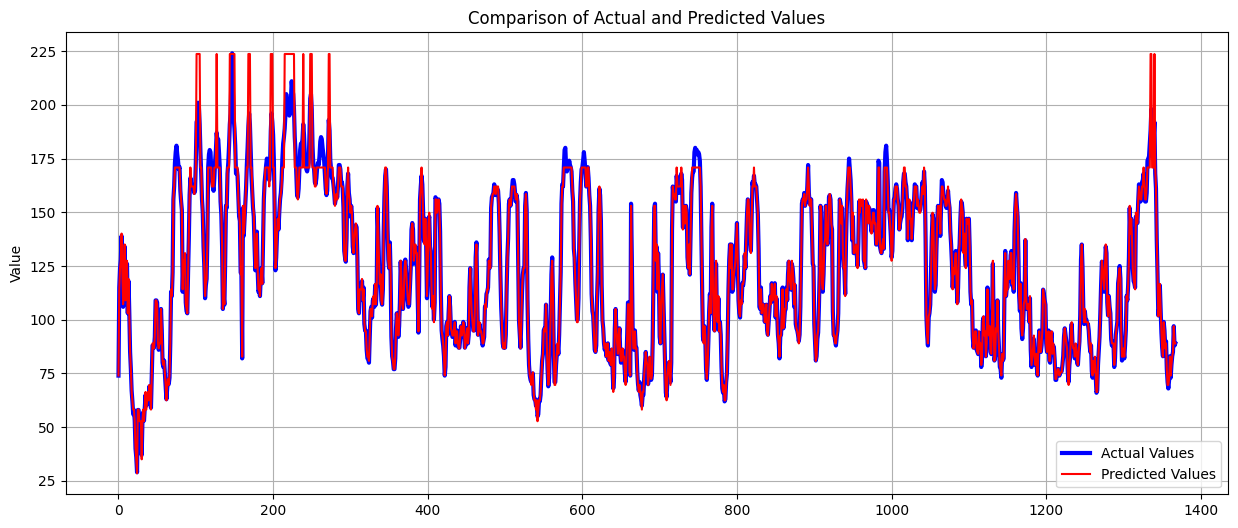

In [ ]:
df.index = pd.to_datetime(df['date'])
#df = df.dropna(subset=['CO', 'NO2', 'pm10', 'pm25', 'AQI'])
dataset_train = df.loc[df.index < pd.to_datetime('10/1/2024')]
dataset_test = df.loc[df.index >= pd.to_datetime('10/1/2024')]
X_train, y_train = dataset_train.iloc[:, :7].values, dataset_train.iloc[:, -1].values.reshape(-1, 1)
X_test, y_test = dataset_test.iloc[:, :7].values, dataset_test.iloc[:, -1].values.reshape(-1, 1)
regressionTree = RegressionDecisionTree(min_samples_split=5, maxDepth=5)
regressionTree.fit(X_train, y_train)
prediction = np.array(regressionTree.predictAll(X_test)).reshape(-1, 1)
plt.figure(figsize=(15, 6))

plt.plot(y_test, label='Actual Values', color='b', linewidth=3)
plt.plot(prediction, label='Predicted Values', color='r', linewidth=1.5)

plt.title('Comparison of Actual and Predicted Values')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("MSE Loss = " + str(mean_squared_error(y_test, prediction)))
print("MAE Loss = " + str(mean_absolute_error(y_test, prediction)))
print("RMSE Loss = " + str(root_mean_squared_error(y_test, prediction)))
print("Accuracy = " + str(regressionTree.score(X_test, y_test)))

MSE Loss = 27.65943456022886
MAE Loss = 1.88948886445883
RMSE Loss = 5.259223760235807
Accuracy = 0.9784409040954962


### **Cross Validation**

In [ ]:
X = df.iloc[:, :7].values
y = df.iloc[:, -1].values.reshape(-1, 1)
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.6, random_state=42)
X_test, X_cv, y_test, y_cv = train_test_split(X_, y_, test_size=0.4, random_state=42)
sample_splits = [2, 5, 10, 25, 50, 100]
depths = [2, 5, 10, 25, 50, 100]

[41.27842189146288, 41.27842189146288, 41.27842189146288, 40.01636227332382, 41.915004428206835, 43.05684246187499]
[0.9956535241632326, 0.9956535241632326, 0.9956535241632326, 0.9952001224038666, 0.9941236896192207, 0.9935041520432025]
[0.9644158010581669, 0.9644158010581669, 0.9644158010581669, 0.9603693375190013, 0.9571779803700311, 0.9564461363070721]


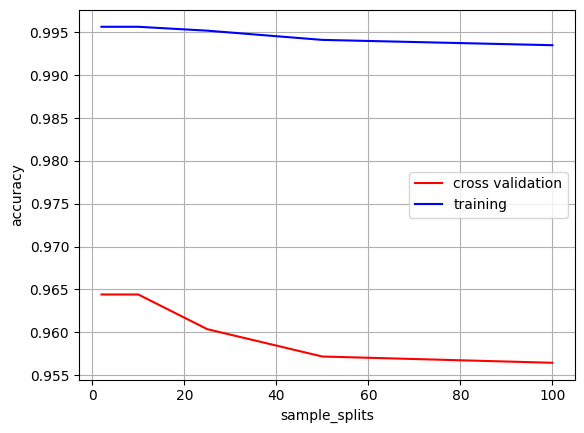

In [ ]:
losses = []
accuracy_CVs = []
accuracy_trainings = []
for n_split in sample_splits:
  regressionTree = RegressionDecisionTree(min_samples_split=n_split, maxDepth=5)
  regressionTree.fit(X_train, y_train)
  prediction = np.array(regressionTree.predictAll(X_test)).reshape(-1, 1)
  performance_CV = regressionTree.score(X_cv, y_cv)
  performance_training = regressionTree.score(X_train, y_train)
  testing = np.sum((y_test - prediction) ** 2) / np.size(y_test)
  losses.append(testing)
  accuracy_CVs.append(performance_CV)
  accuracy_trainings.append(performance_training)
print(losses)
print(accuracy_trainings)
print(accuracy_CVs)
plt.xlabel("sample_splits")
plt.ylabel("accuracy")
plt.plot(sample_splits, accuracy_CVs, c='r')
plt.plot(sample_splits, accuracy_trainings, c='b')
plt.legend(['cross validation', 'training'])
plt.grid()
plt.show()

#### **DEPTH**

[60.02326786753124, 41.27842189146288, 35.49914247519486, 35.48437707090788, 35.48437707090788, 35.48437707090788]
[0.9486730413407058, 0.9956535241632326, 0.999908736065249, 0.9999315666151978, 0.9999315666151978, 0.9999315666151978]
[0.9514455950554523, 0.9644158010581669, 0.9675334811683912, 0.9675542931716657, 0.9675542931716657, 0.9675542931716657]


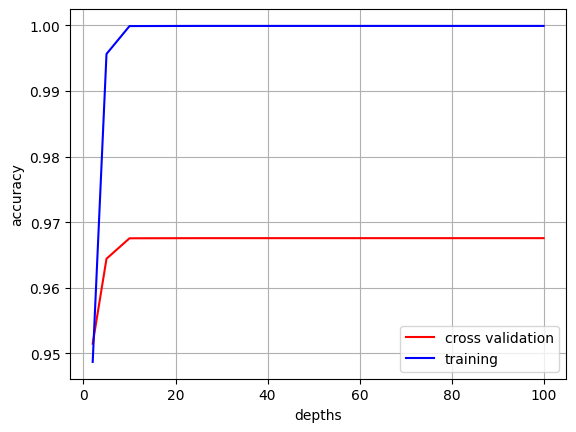

In [ ]:
losses = []
accuracy_CVs = []
accuracy_trainings = []
for depth in depths:
  regressionTree = RegressionDecisionTree(min_samples_split=5, maxDepth=depth)
  regressionTree.fit(X_train, y_train)
  prediction = np.array(regressionTree.predictAll(X_test)).reshape(-1, 1)
  performance_CV = regressionTree.score(X_cv, y_cv)
  performance_training = regressionTree.score(X_train, y_train)
  testing = np.sum((y_test - prediction) ** 2) / np.size(y_test)
  losses.append(testing)
  accuracy_CVs.append(performance_CV)
  accuracy_trainings.append(performance_training)
print(losses)
print(accuracy_trainings)
print(accuracy_CVs)
plt.xlabel("depths")
plt.ylabel("accuracy")
plt.plot(depths, accuracy_CVs, c='r')
plt.plot(depths, accuracy_trainings, c='b')
plt.legend(['cross validation', 'training'])
plt.grid()
plt.show()

#### **VISUALIZE DEPTH AND MIN_SAMPLES_SPLIT**

In [ ]:
losses = np.zeros((len(depths), len(sample_splits)))
accuracy_CVs = np.zeros((len(depths), len(sample_splits)))
for i, depth in enumerate(depths):
  for j, n_split in enumerate(sample_splits):
    model = RegressionDecisionTree(n_split, depth)
    model.fit(X_train, y_train)
    prediction = np.array(model.predictAll(X_test)).reshape(-1, 1)
    performance = model.score(X_cv, y_cv)
    accuracy_CVs[i, j] = performance
    loss = np.sum((prediction - y_test) ** 2) / len(y_test)
    losses[i, j] = loss
accuracy = pd.DataFrame(accuracy_CVs, index=depths, columns=sample_splits)
error = pd.DataFrame(losses, index=depths, columns=sample_splits)

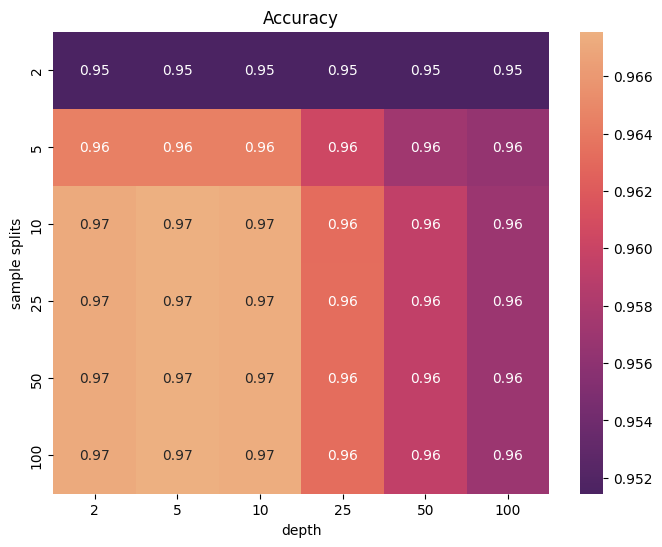

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(accuracy, annot=True, cmap="flare_r", xticklabels=depths, yticklabels=sample_splits)
plt.title("Accuracy")
plt.xlabel("depth")
plt.ylabel("sample splits")
plt.show()

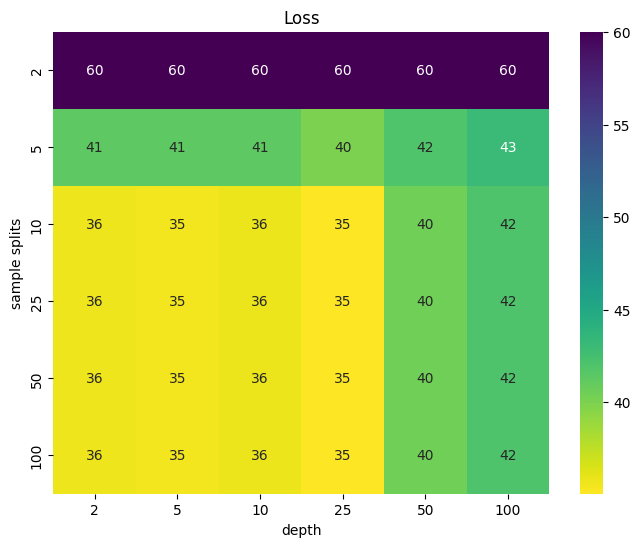

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(error, annot=True, cmap="viridis_r", xticklabels=depths, yticklabels=sample_splits)
plt.title("Loss")
plt.xlabel("depth")
plt.ylabel("sample splits")
plt.show()

## **RANDOM FOREST**

In [ ]:
class RandomForest():
  def __init__(self, n_trees = None, min_samples_split=0, maxDepth=0):
    self.n_trees = n_trees
    self.min_samples_split = min_samples_split
    self.maxDepth = maxDepth
    self.trees = []

  def boostrap_sample(self, X, y):
    n_samples = X.shape[0]
    index = np.random.choice(n_samples, n_samples, replace=True)
    return X[index], y[index]

  def fit(self, X, y):
    self.trees = []
    for _ in range(self.n_trees):
      X, y =  self.boostrap_sample(X, y)
      tree = RegressionDecisionTree(min_samples_split=self.min_samples_split, maxDepth=self.maxDepth)
      tree.fit(X, y)
      self.trees.append(tree)

  def predict(self, X):
    predictions = [tree.predictAll(X) for tree in self.trees]
    return np.mean(predictions, axis=0)

  def score(self, X, y):
    predictions = self.predict(X).reshape(-1, 1)
    performance = 1 - np.sum((y - predictions)**2) / np.sum((y - np.mean(y))**2)
    return performance


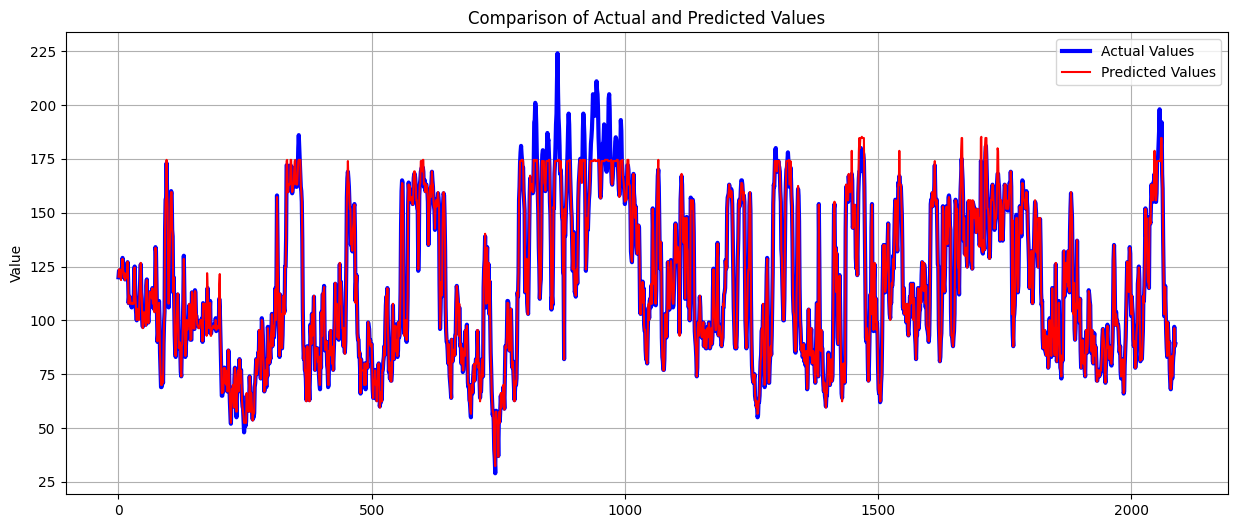

In [ ]:
df.index = pd.to_datetime(df['date'])
#df.dropna(subset = ['CO', 'NO2', 'pm10', 'pm25', 'AQI'])
dataset_train = df.loc[df.index < pd.to_datetime('09/1/2024')]
dataset_test = df.loc[df.index >= pd.to_datetime('09/1/2024')]
X_train, y_train = dataset_train.iloc[:, :7].values, dataset_train.iloc[:, -1].values.reshape(-1, 1)
X_test, y_test = dataset_test.iloc[:, :7].values, dataset_test.iloc[:, -1].values.reshape(-1, 1)
model = RandomForest(n_trees=5, min_samples_split=5, maxDepth=5)
model.fit(X_train, y_train)
prediction = np.array(model.predict(X_test)).reshape(-1, 1)

plt.figure(figsize=(15, 6))

plt.plot(y_test, label='Actual Values', color='b', linewidth=3)
plt.plot(prediction, label='Predicted Values', color='r', linewidth=1.5)

plt.title('Comparison of Actual and Predicted Values')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("MSE Loss = " + str(mean_squared_error(y_test, prediction)))
print("MAE Loss = " + str(mean_absolute_error(y_test, prediction)))
print("RMSE Loss = " + str(root_mean_squared_error(y_test, prediction)))
print("Accuracy = " + str(model.score(X_test, y_test)))

MSE Loss = 27.65943456022886
MAE Loss = 1.88948886445883
RMSE Loss = 5.259223760235807
Accuracy = 0.9995330912152152


### **Cross Validation**

In [ ]:
X = df.iloc[:, :7].values
y = df.iloc[:, -1].values.reshape(-1, 1)
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.7, random_state=42)
X_test, X_cv, y_test, y_cv = train_test_split(X_, y_, test_size=0.3, random_state=42)
sample_splits = [2, 5, 10, 25, 50]
depths = [2, 5, 10, 25, 50]
n_trees = [1, 2, 5, 10, 20]

#### **NUMBER OF TREES AND MIN SAMPLES SPLIT**

In [ ]:
accuracy = np.zeros((len(n_trees), len(sample_splits)))
for i, tree in enumerate(n_trees):
  for j, n_split in enumerate(sample_splits):
    model = RandomForest(tree, min_samples_split=n_split, maxDepth=5)
    model.fit(X_train, y_train)
    performance = model.score(X_cv, y_cv)
    accuracy[i, j] = performance
efficiency = pd.DataFrame(accuracy, index=n_trees, columns=sample_splits)

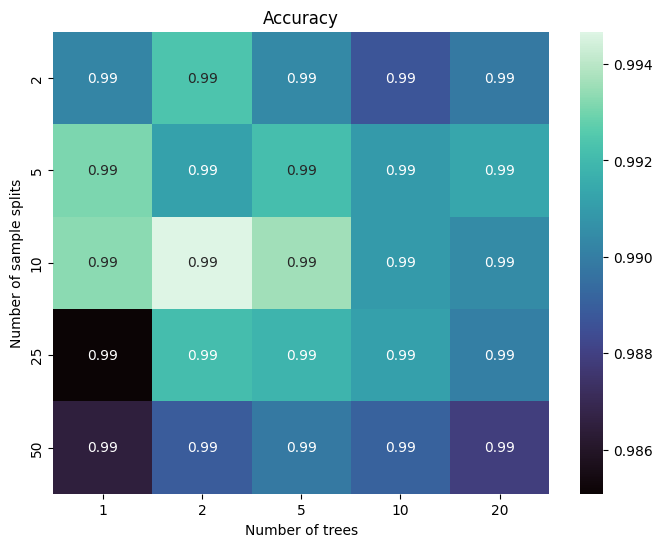

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(efficiency, annot=True, cmap="mako", xticklabels=n_trees, yticklabels=sample_splits)
plt.title("Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Number of sample splits")
plt.show()

#### **NUMBER OF TREES AND DEPTHS**

In [ ]:
accuracy = np.zeros((len(n_trees), len(depths)))
for i, tree in enumerate(n_trees):
  for j, depth in enumerate(depths):
    model = RandomForest(tree, min_samples_split=3, maxDepth=depth)
    model.fit(X_train, y_train)
    performance = model.score(X_cv, y_cv)
    accuracy[i, j] = performance
efficiency = pd.DataFrame(accuracy, index=n_trees, columns=depths)

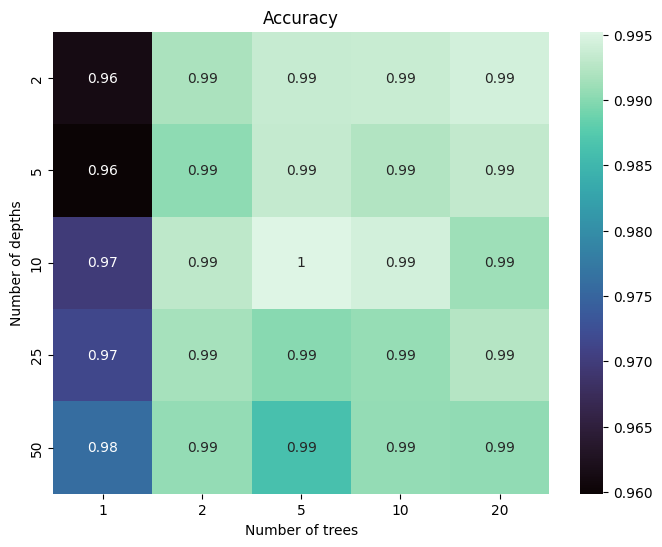

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(efficiency, annot=True, cmap="mako", xticklabels=n_trees, yticklabels=depths)
plt.title("Accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Number of depths")
plt.show()

## **GRADIENT BOOSTING**

In [ ]:
class GradientBoosting():
  def __init__(self, n_trees = None, learning_rate = None, maxDepth = None):
    self.n_trees = n_trees
    self.learning_rate = learning_rate
    self.maxDepth = maxDepth
    self.trees = []

  def fit(self, X, y):
    self.trees = []
    self.F0 = np.mean(y)
    Fm = self.F0
    for _ in range(self.n_trees):
      tree = RegressionDecisionTree(min_samples_split=3, maxDepth=self.maxDepth)
      tree.fit(X, y - Fm)
      Fm = Fm + self.learning_rate * np.array(tree.predictAll(X)).reshape(-1, 1)
      self.trees.append(tree)

  def predict(self, X):
    return self.F0 + self.learning_rate * np.sum([tree.predictAll(X) for tree in self.trees], axis=0)

  def score(self, X, y):
    prediction = self.predict(X).reshape(-1, 1)
    performance = 1 - np.sum((y - prediction) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return performance

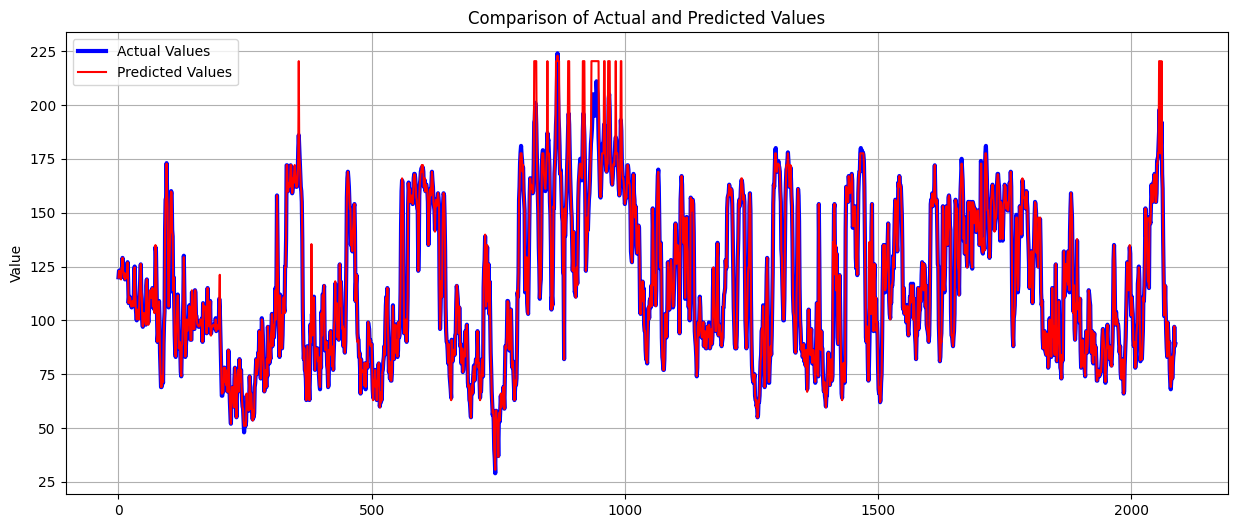

In [ ]:
df.index = pd.to_datetime(df['date'])
dataset_train = df.loc[df.index < pd.to_datetime('09/1/2024')]
dataset_test = df.loc[df.index >= pd.to_datetime('09/1/2024')]
X_train, y_train = dataset_train.iloc[:, :7].values, dataset_train.iloc[:, -1].values.reshape(-1, 1)
X_test, y_test = dataset_test.iloc[:, :7].values, dataset_test.iloc[:, -1].values.reshape(-1, 1)
model = GradientBoosting(n_trees=5, learning_rate=0.8, maxDepth=5)
model.fit(X_train, y_train)
prediction = np.array(model.predict(X_test)).reshape(-1, 1)
loss = np.sum((y_test - prediction) ** 2) / len(y_test)

plt.figure(figsize=(15, 6))

plt.plot(y_test, label='Actual Values', color='b', linewidth=3)
plt.plot(prediction, label='Predicted Values', color='r', linewidth=1.5)

plt.title('Comparison of Actual and Predicted Values')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("MSE Loss = " + str(mean_squared_error(y_test, prediction)))
print("MAE Loss = " + str(mean_absolute_error(y_test, prediction)))
print("RMSE Loss = " + str(root_mean_squared_error(y_test, prediction)))
print("Accuracy = " + str(model.score(X_test, y_test)))

MSE Loss = 19.956942454614442
MAE Loss = 0.9768343651842355
RMSE Loss = 4.467319381308487
Accuracy = 0.9842638031327059


### **Cross validation**

In [ ]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size = 0.7, random_state = 42)
X_test, X_CV, y_test, y_CV = train_test_split(X_, y_, test_size = 0.4, random_state = 42)
num_trees = [1, 3, 5, 10, 20]
learning_rates = [0.001, 0.01, 0.1, 0.5, 0.8]

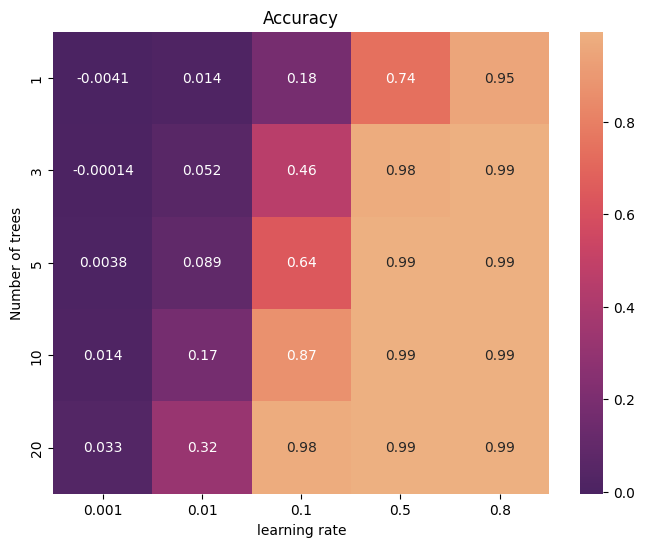

In [ ]:
accuracy = np.zeros((len(learning_rates), len(num_trees)))
for i, n_tree in enumerate(num_trees):
  for j, lr in enumerate(learning_rates):
    model = GradientBoosting(n_trees=n_tree, learning_rate=lr, maxDepth=5)
    model.fit(X_train, y_train)
    performance = model.score(X_cv, y_cv)
    accuracy[i, j] = performance
efficiency = pd.DataFrame(accuracy, index=learning_rates, columns=num_trees)
plt.figure(figsize=(8, 6))
sns.heatmap(efficiency, annot=True, cmap="flare_r", xticklabels=learning_rates, yticklabels=num_trees)
plt.title("Accuracy")
plt.xlabel("learning rate")
plt.ylabel("Number of trees")
plt.show()

## **XGBoost**

In [ ]:
def gradients(y, y_pred):
  return (y_pred - y)

def hessians(y, y_pred):
  return np.ones(len(y))

In [ ]:
class Node():
  def __init__(self, best_feature=None, best_threshold=None, left=None, right=None, gain=None, value=None):
    self.best_feature = best_feature
    self.best_threshold = best_threshold
    self.left = left
    self.right = right
    self.gain = gain
    self.value = value

In [ ]:
class XGBoostTree():
    def __init__(self, min_samples_split=None, maxDepth=None, gamma=None, lamda=None):
        self.min_samples_split = min_samples_split
        self.maxDepth = maxDepth
        self.gamma = gamma
        self.lamda = lamda
        self.root = None

    def generateTree(self, dataset, depth=0, Fm=None):
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape
        if Fm is None:
          Fm = np.full(len(y), np.mean(y))
        else:
          Fm = Fm[:n_samples]
        best_split = {}
        if n_samples >= self.min_samples_split and depth <= self.maxDepth:
            best_split = self.choosingBestSplit(dataset, n_samples, n_features, Fm)
            if best_split and best_split["gain"] > 0:
                left_subtree = self.generateTree(best_split["left"], depth + 1, Fm)
                right_subtree = self.generateTree(best_split["right"], depth + 1, Fm)
                return Node(best_split["best_feature"], best_split["best_threshold"], left_subtree, right_subtree, best_split["gain"])
        leaf_node = self.computeLeaf(y, Fm)
        return Node(value=leaf_node)

    def choosingBestSplit(self, dataset, n_samples, n_features, Fm):
        best_split = {}
        best_gain = -float("inf")

        sum_g = np.sum(gradients(dataset[:, -1], Fm))
        sum_h = np.sum(hessians(dataset[:, -1], Fm))

        for feature_index in range(n_features):
            feature_values = dataset[:, feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                dataset_left, dataset_right, indices_left, indices_right = self.getSplit(dataset, feature_index, threshold)
                if dataset_left.size == 0 or dataset_right.size == 0:
                    continue
                Fm_left = Fm[indices_left]
                Fm_right = Fm[indices_right]

                sum_g_left = np.sum(gradients(dataset_left[:, -1], Fm_left))
                sum_h_left = np.sum(hessians(dataset_left[:, -1], Fm_left))
                sum_g_right = np.sum(gradients(dataset_right[:, -1], Fm_right))
                sum_h_right = np.sum(hessians(dataset_right[:, -1], Fm_right))

                gain = (sum_g_left ** 2 / (sum_h_left + self.lamda)) + \
                       (sum_g_right ** 2 / (sum_h_right + self.lamda)) - \
                       (sum_g ** 2 / (sum_h + self.lamda)) - self.gamma

                if gain > best_gain:
                    best_split = {
                        "best_feature": feature_index,
                        "best_threshold": threshold,
                        "left": dataset_left,
                        "right": dataset_right,
                        "gain": gain
                    }
                    best_gain = gain

        return best_split

    def getSplit(self, dataset, feature_index, threshold):
      indices_left = np.where(dataset[:, feature_index] <= threshold)[0]
      indices_right = np.where(dataset[:, feature_index] > threshold)[0]
      dataset_left = dataset[indices_left]
      dataset_right = dataset[indices_right]
      return dataset_left, dataset_right, indices_left, indices_right

    def fit(self, X, y):
        Fm = np.full(len(y), np.mean(y))
        dataset = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        self.root = self.generateTree(dataset, depth=0, Fm=Fm)

    def computeLeaf(self, y, Fm):
        sum_g = np.sum(gradients(y, Fm))
        sum_h = np.sum(hessians(y, Fm))
        return -sum_g / (sum_h + self.lamda)

    def predict(self, x, newTree):
        if newTree.value is not None:
            return newTree.value
        feature_value = x[newTree.best_feature]
        if feature_value <= newTree.best_threshold:
            return self.predict(x, newTree.left)
        else:
            return self.predict(x, newTree.right)

    def predictAll(self, X):
        return [self.predict(x, self.root) for x in X]


In [ ]:
class XGBoostModel():
  def __init__(self, n_trees=None, learning_rate=None, lamda=None, gamma=None, min_samples_split=None, maxDepth=None):
    self.n_trees = n_trees
    self.learning_rate = learning_rate
    self.lamda = lamda
    self.gamma = gamma
    self.min_samples_split = min_samples_split
    self.maxDepth = maxDepth

  def fit(self, X, y):
    self.trees = []
    self.F0 = np.mean(y)
    Fm = self.F0
    for _ in range(self.n_trees):
      tree = XGBoostTree(min_samples_split=self.min_samples_split, maxDepth=self.maxDepth, gamma=self.gamma, lamda=self.lamda)
      tree.fit(X, y - Fm)
      Fm = Fm + self.learning_rate * np.array(tree.predictAll(X)).reshape(-1, 1)
      self.trees.append(tree)

  def predict(self, X):
    return self.F0 + self.learning_rate * np.sum([tree.predictAll(X) for tree in self.trees], axis=0)

  def score(self, X, y):
    prediction = self.predict(X).reshape(-1, 1)
    performance = 1 - np.sum((y - prediction) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return performance


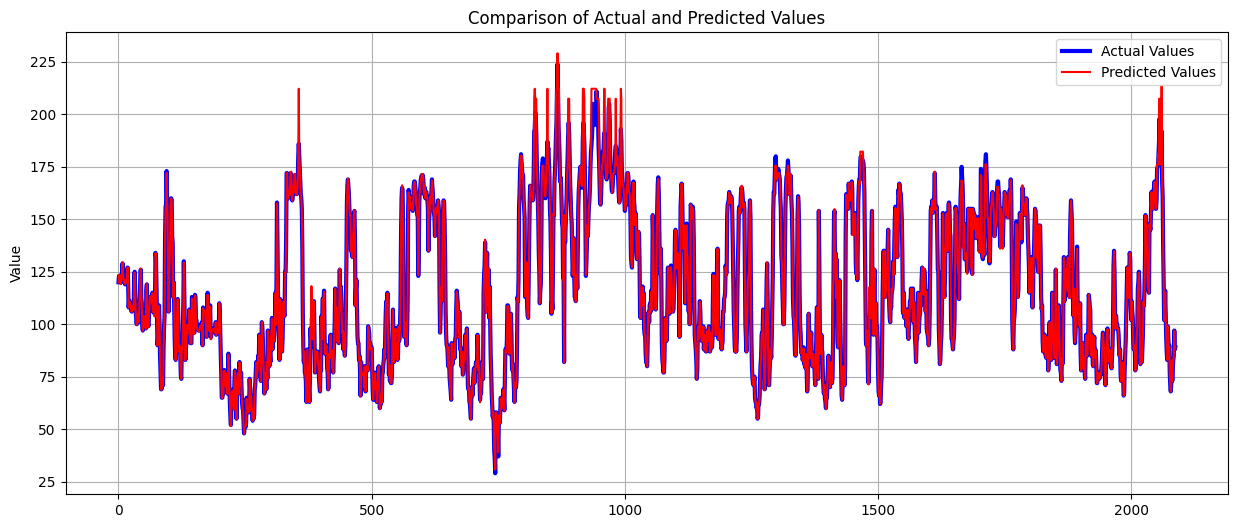

In [ ]:
#df = df.dropna(subset=['CO', 'NO2', 'pm10', 'pm25', 'AQI'])
df.index = pd.to_datetime(df['date'] + ' ' + df['time'])
dataset_train = df.loc[df.index < pd.to_datetime('09/1/2024')]
dataset_test = df.loc[df.index >= pd.to_datetime('09/1/2024')]

X_train, y_train = dataset_train.iloc[:, :7].values, dataset_train.iloc[:, -1].values.reshape(-1, 1)
X_test, y_test = dataset_test.iloc[:, :7].values, dataset_test.iloc[:, -1].values.reshape(-1, 1)
model = XGBoostModel(n_trees=10, learning_rate=0.8, lamda=1, gamma=0, min_samples_split=10, maxDepth=10)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
plt.figure(figsize=(15, 6))

plt.plot(y_test, label='Actual Values', color='b', linewidth=3)
plt.plot(prediction, label='Predicted Values', color='r', linewidth=1.5)

plt.title('Comparison of Actual and Predicted Values')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("MSE Loss = " + str(mean_squared_error(y_test, prediction)))
print("MAE Loss = " + str(mean_absolute_error(y_test, prediction)))
print("RMSE Loss = " + str(root_mean_squared_error(y_test, prediction)))
print("Accuracy = " + str(model.score(X_test, y_test)))

MSE Loss = 8.462598556822067
MAE Loss = 0.7575976815673098
RMSE Loss = 2.909054581272422
Accuracy = 0.9933271783890804


## **STACKING**

In [ ]:
class Stacking():
  def __init__(self, models=[]):
    self.models = models

  def fit(self, X, y):
    self.model_prediction = []
    for model in self.models:
      model.fit(X, y)
      prediction = (model.predict(X)).reshape(-1, 1)
      self.model_prediction.append(prediction)
    self.model_prediction = np.array(self.model_prediction)
    stacking = np.column_stack(self.model_prediction)
    self.stacking_ensemble = LinearRegression()
    self.stacking_ensemble.fit(stacking, y)

  def predict(self, X):
    model_predictions = [model.predict(X) for model in self.models]
    stacking_prediction = np.column_stack(model_predictions)
    predictions = self.stacking_ensemble.predict(stacking_prediction)
    return predictions

  def score(self, X, y):
    prediction = self.predict(X)
    performance = 1 - np.sum((y - prediction) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return performance

0.99456148972471
2.0664857864241917


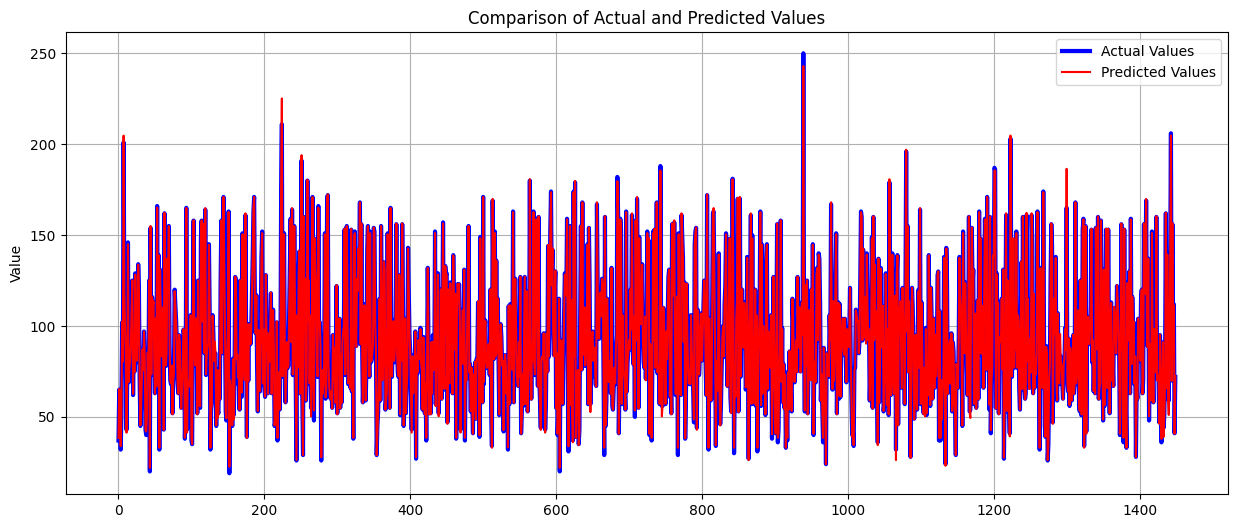

In [ ]:
X = df.iloc[:, :7].values
y = df.iloc[:, -1].values.reshape(-1, 1)
X_train, X_, y_train, y_ = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_test, X_CV, y_test, y_CV = train_test_split(X_, y_, test_size = 0.5, random_state = 42)

model1 = RandomForest(n_trees=5, min_samples_split=5, maxDepth=5)
model2 = GradientBoosting(n_trees=5, learning_rate=0.8, maxDepth=5)
model3 = LinearRegression()
model4 = XGBoostModel(n_trees=5, learning_rate=0.8, lamda=1, gamma=0, min_samples_split=5, maxDepth=5)

models = [model1, model2, model3, model4]
model = Stacking(models)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

performance = model.score(X_CV, y_CV)
print(performance)

print(mean_squared_error(y_test, y_pred))
plt.figure(figsize=(15, 6))

plt.plot(y_test, label='Actual Values', color='b', linewidth=3)
plt.plot(y_pred, label='Predicted Values', color='r', linewidth=1.5)

plt.title('Comparison of Actual and Predicted Values')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("MSE Loss = " + str(mean_squared_error(y_test, y_pred)))
print("MAE Loss = " + str(mean_absolute_error(y_test, y_pred)))
print("RMSE Loss = " + str(root_mean_squared_error(y_test, y_pred)))
print("Accuracy = " + str(model.score(X_test, y_test)))

MSE Loss = 2.0664857864241917
MAE Loss = 0.5516930025631048
RMSE Loss = 1.4375276645769959
Accuracy = 0.998361298934236


## **FUTURE PREDICTIONS**

### **Machine Learning**

In [ ]:
def create_features(df):
  if 'datetime' not in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df['date']):
            df['datetime'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['time'])
        else:
            df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
  if 'isFuture' not in df.columns:
    df['isFuture'] = False
  df = df[['CO', 'NO2', 'pm10', 'pm25', 'Temperature', 'Humidity', 'Wind speed', 'date', 'time', 'datetime', 'AQI', 'isFuture']]
  df = df.set_index('datetime')
  df['hour'] = df.index.hour
  df['day'] = df.index.day
  df['month'] = df.index.month
  return df
df = create_features(df)

In [ ]:
def add_lags(df):
    df['lag1'] = df['CO'].shift(24 * 112)
    df['lag2'] = df['NO2'].shift(24 * 84)
    df['lag3'] = df['pm10'].shift(24 * 56)
    df['lag4'] = df['pm25'].shift(24 * 28)
    #df = df.dropna()
    return df

In [ ]:
cop = df.copy()
cop['datetime'] = pd.to_datetime(cop['date'] + ' ' + cop['time'])
cop = add_lags(cop)
cop = cop.set_index('datetime')

In [ ]:
'''cop['lag1'] = abs(cop['lag1'].fillna(cop['lag1'].median()))
cop['lag2'] = abs(cop['lag2'].fillna(cop['lag2'].median()))
cop['lag3'] = abs(cop['lag3'].fillna(cop['lag3'].median()))
cop['lag4'] = abs(cop['lag4'].fillna(cop['lag4'].median()))'''

"cop['lag1'] = abs(cop['lag1'].fillna(cop['lag1'].median()))\ncop['lag2'] = abs(cop['lag2'].fillna(cop['lag2'].median()))\ncop['lag3'] = abs(cop['lag3'].fillna(cop['lag3'].median()))\ncop['lag4'] = abs(cop['lag4'].fillna(cop['lag4'].median()))"

In [ ]:
cop['date'] = pd.to_datetime(cop['date'])
dataset_train = cop.loc[cop['date'] < pd.to_datetime('08/01/2024 12:00')]
dataset_test = cop.loc[(cop['date'] < pd.to_datetime('10/01/2024 12:00')) & (cop['date'] >= pd.to_datetime('08/01/2024 12:00'))]
dataset_cross = cop.loc[cop['date'] >= pd.to_datetime('10/01/2024 12:00')]
features = ['lag1', 'lag2', 'lag3', 'lag4', 'Temperature', 'Humidity', 'Wind speed']
target = 'AQI'
X_train, y_train = dataset_train[features].values, dataset_train[target].values.reshape(-1, 1)
X_test, y_test = dataset_test[features].values, dataset_test[target].values.reshape(-1, 1)
X_cross, y_cross = dataset_cross[features].values, dataset_cross[target].values.reshape(-1, 1)

print(y_train.shape)
print(y_test.shape)
print(y_cross.shape)

(4442, 1)
(1464, 1)
(1344, 1)


In [ ]:
#model = XGBoostModel(n_trees=50, learning_rate=0.8, lamda=0.1, gamma=0, min_samples_split=5, maxDepth=20)
model1 = RandomForest(n_trees=5, min_samples_split=3, maxDepth=15)
model2 = GradientBoosting(n_trees=5, learning_rate=0.5, maxDepth=15)
model3 = XGBoostModel(n_trees=5, learning_rate=0.5, lamda=0.2, gamma=0, min_samples_split=3, maxDepth=10)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

models = [model1, model2, model3]
model4 = Stacking(models)
model4.fit(X_train, y_train)
prediction = model4.predict(X_test)

In [ ]:

prediction1 = model1.predict(X_test)
prediction2 = model2.predict(X_test)
prediction3 = model3.predict(X_test)

In [ ]:
print(root_mean_squared_error(y_test, prediction1))
print(mean_squared_error(y_test, prediction1))
print(mean_absolute_error(y_test, prediction1))
print(mean_absolute_percentage_error(y_test, prediction1))
print('\n')

print(root_mean_squared_error(y_test, prediction2))
print(mean_squared_error(y_test, prediction2))
print(mean_absolute_error(y_test, prediction2))
print(mean_absolute_percentage_error(y_test, prediction2))
print('\n')

print(root_mean_squared_error(y_test, prediction3))
print(mean_squared_error(y_test, prediction3))
print(mean_absolute_error(y_test, prediction3))
print(mean_absolute_percentage_error(y_test, prediction3))


39.84907145745542
1587.9484960213886
29.855493809982026
0.27359430822203307


39.25759484325393
1541.1587528770779
29.542110830088333
0.27757602346824733


37.46570227769054
1403.678847160546
28.2004804953235
0.27881687029126634


In [ ]:
print(root_mean_squared_error(y_test, prediction))
print(mean_squared_error(y_test, prediction))
print(mean_absolute_error(y_test, prediction))
print(mean_absolute_percentage_error(y_test, prediction))
print(len(prediction))

41.28123004056867
1704.1399536623494
31.504177663344535
0.3056504675872034
1464


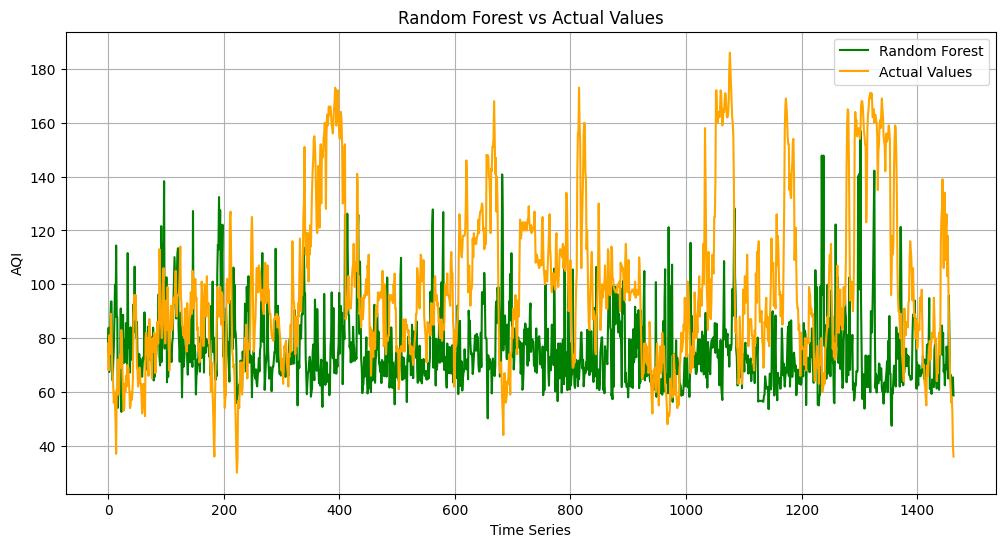

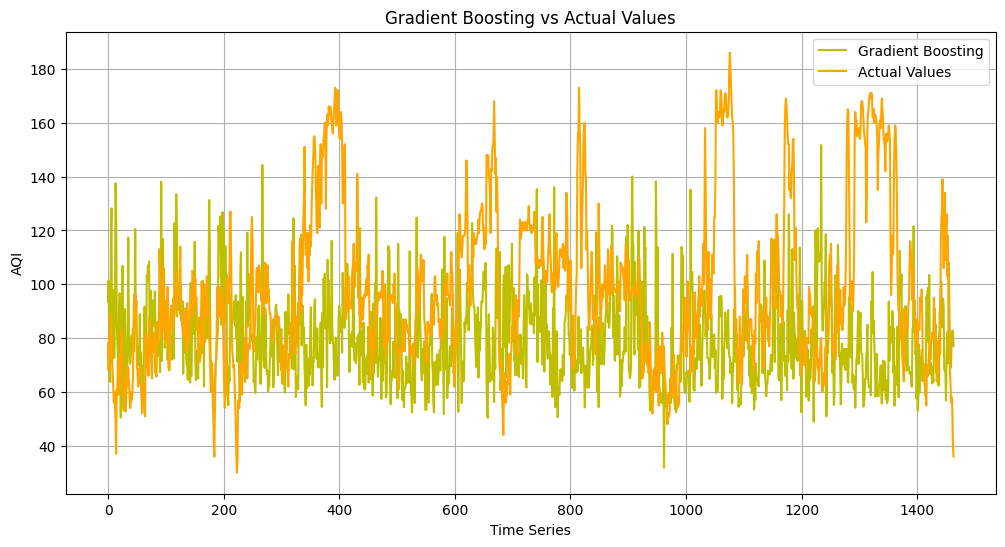

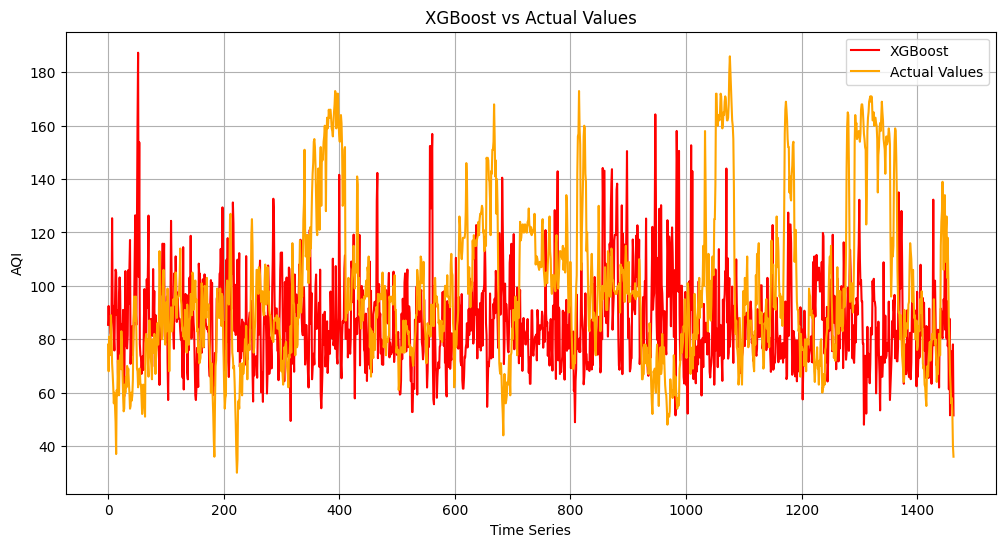

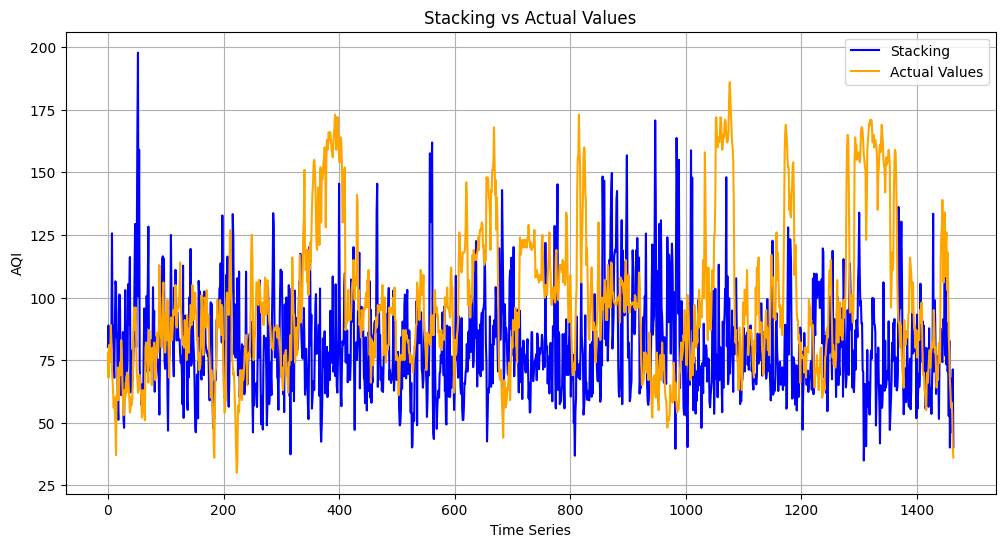

In [ ]:
# Biểu đồ cho Random Forest
plt.figure(figsize=(12, 6))
plt.plot(prediction1, label='Random Forest', color='g')
plt.plot(y_test, label='Actual Values', color='orange')
plt.legend()
plt.ylabel('AQI')
plt.xlabel('Time Series')
plt.grid()
plt.title('Random Forest vs Actual Values')
plt.show()

# Biểu đồ cho Gradient Boosting
plt.figure(figsize=(12, 6))
plt.plot(prediction2, label='Gradient Boosting', color='y')
plt.plot(y_test, label='Actual Values', color='orange')
plt.ylabel('AQI')
plt.xlabel('Time Series')
plt.legend()
plt.grid()
plt.title('Gradient Boosting vs Actual Values')
plt.show()

# Biểu đồ cho XGBoost
plt.figure(figsize=(12, 6))
plt.plot(prediction3, label='XGBoost', color='r')
plt.plot(y_test, label='Actual Values', color='orange')
plt.ylabel('AQI')
plt.xlabel('Time Series')
plt.legend()
plt.grid()
plt.title('XGBoost vs Actual Values')
plt.show()

# Biểu đồ cho Stacking
plt.figure(figsize=(12, 6))
plt.plot(prediction, label='Stacking', color='b')
plt.plot(y_test, label='Actual Values', color='orange')
plt.ylabel('AQI')
plt.xlabel('Time Series')
plt.legend()
plt.grid()
plt.title('Stacking vs Actual Values')
plt.show()


In [ ]:
future = pd.date_range('2024-11-27','2024-12-31', freq='1h')
future_df = pd.DataFrame(future, columns=['datetime'])
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_predictions = df_and_future.query('isFuture').copy()
prediction1 = model1.predict(future_predictions[features].values)
prediction2 = model2.predict(future_predictions[features].values)
prediction3 = model3.predict(future_predictions[features].values)
prediction4 = model4.predict(future_predictions[features].values)
prediction1 = prediction1.reshape(-1, 1)
prediction2 = prediction2.reshape(-1, 1)
prediction3 = prediction3.reshape(-1, 1)
prediction4 = prediction4.reshape(-1, 1)


In [ ]:
avg1, avg2, avg3, avg4 = [], [], [], []
i = 0
while i <= 34 * 24:
  avg1.append(np.mean(prediction1[i:i+24]))
  avg2.append(np.mean(prediction2[i:i+24]))
  avg3.append(np.mean(prediction3[i:i+24]))
  avg4.append(np.mean(prediction4[i:i+24]))
  i += 24
avg1, avg2, avg3, avg4 = np.array(avg1), np.array(avg2), np.array(avg3), np.array(avg4)

def getColor(avg):
  colors = []
  for AQI_value in avg:
    if AQI_value <= 50:
      colors.append('green')
    elif AQI_value <= 100:
      colors.append('yellow')
    elif AQI_value <= 150:
      colors.append('orange')
    elif AQI_value <= 200:
      colors.append('red')
    else:
      colors.append('purple')
  return colors
date = future_df['datetime'].dt.date.unique()

color1, color2, color3, color4 = getColor(avg1), getColor(avg2), getColor(avg3), getColor(avg4)


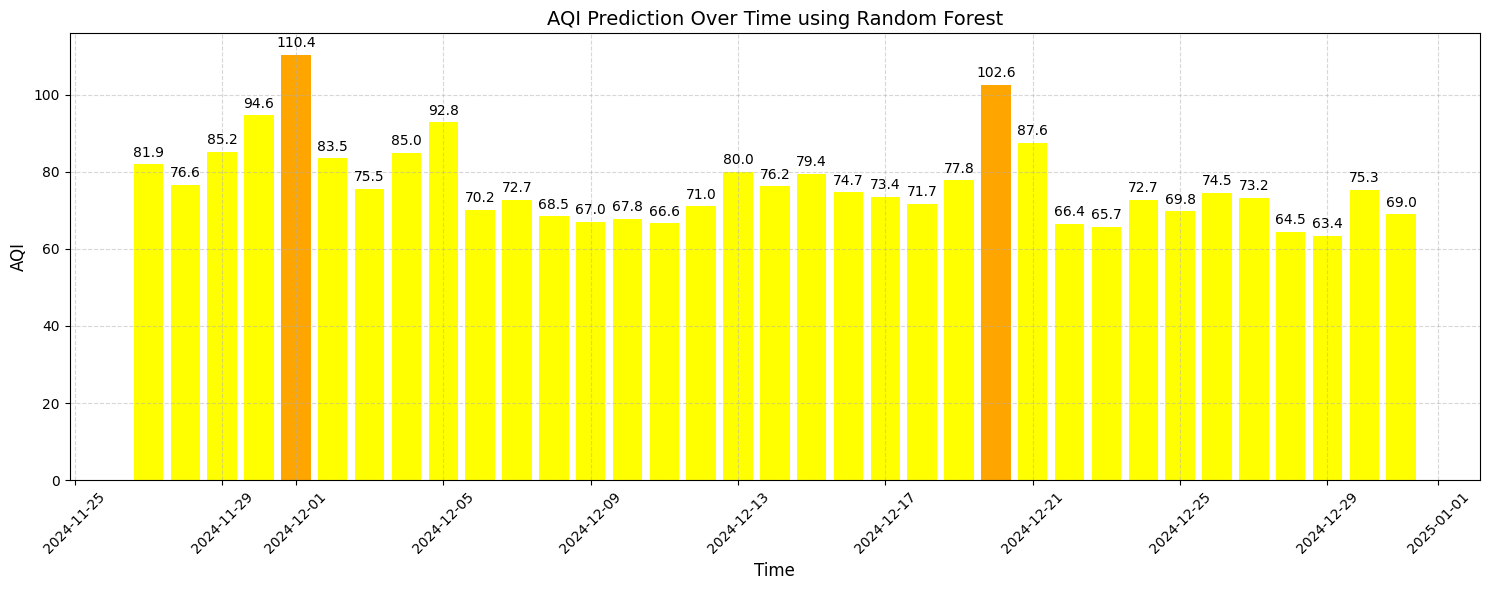

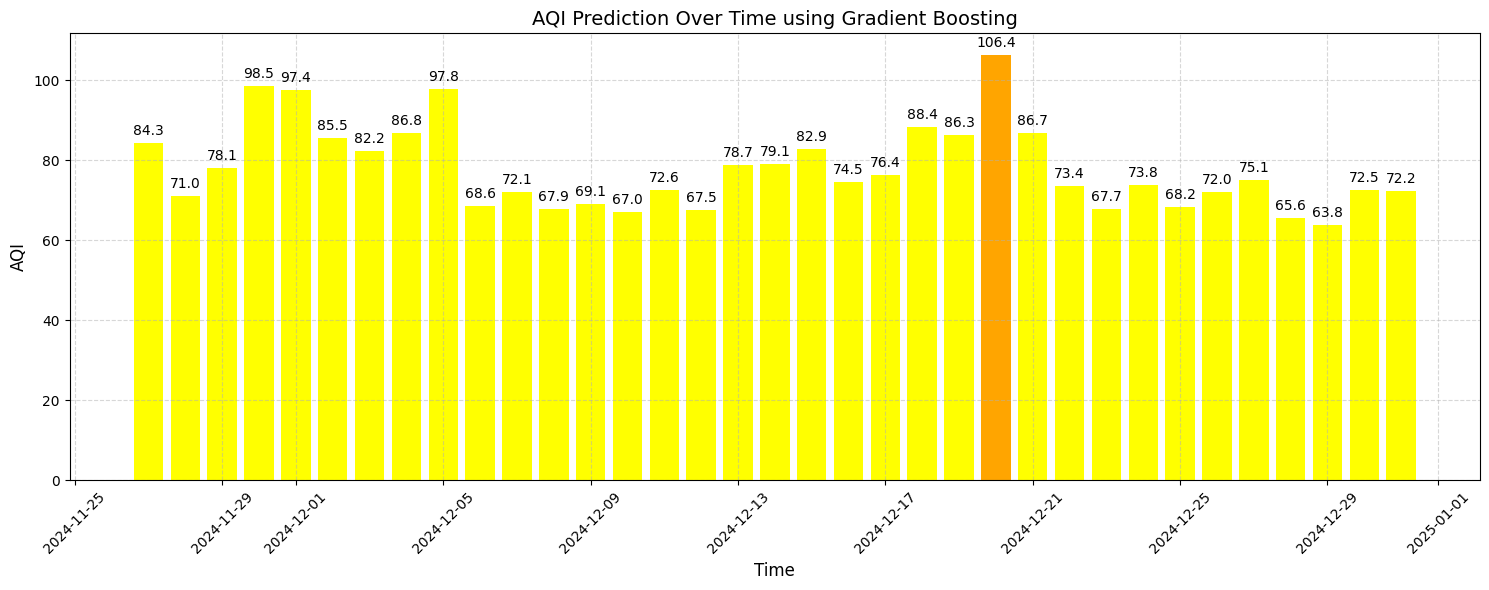

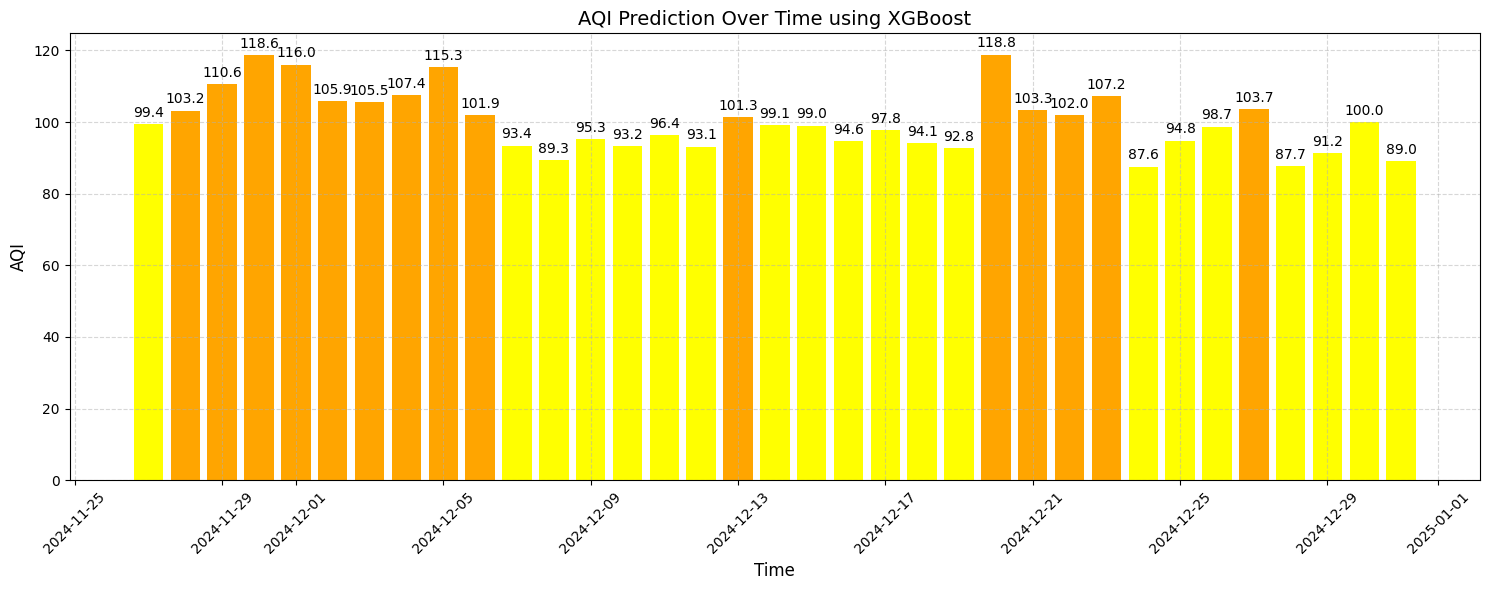

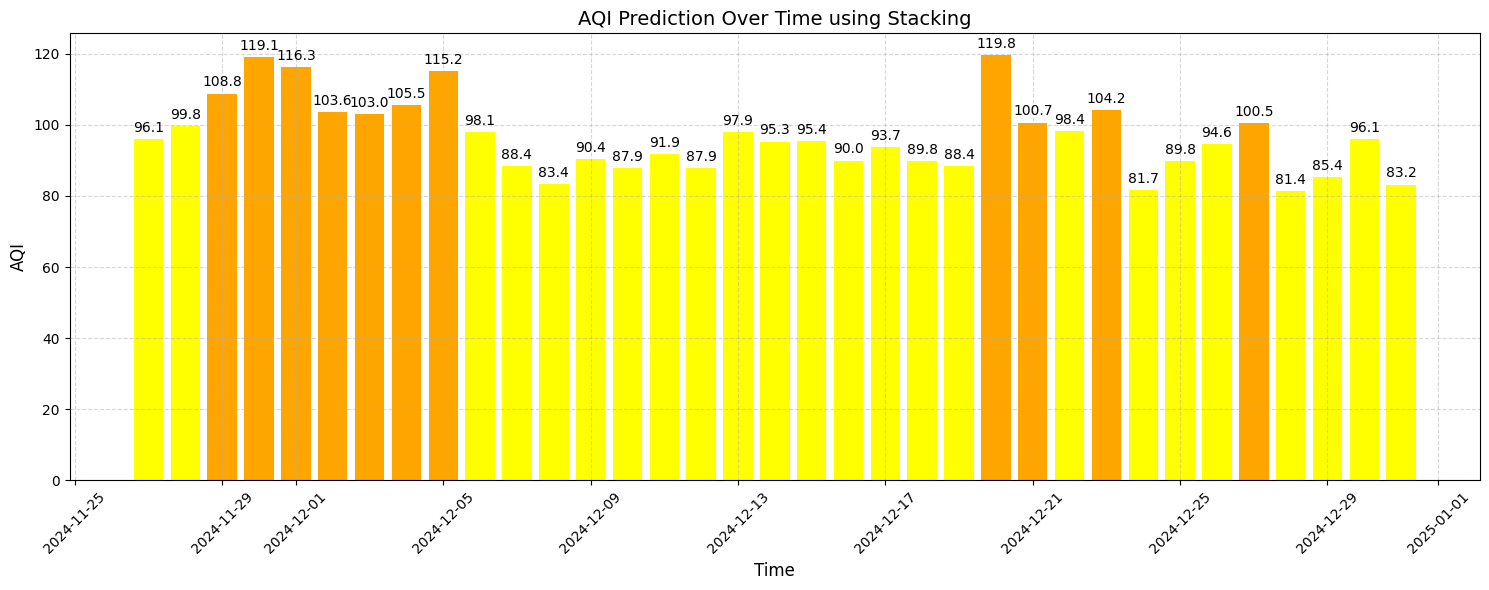

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar(date, avg1, color=color1)
for i, value in enumerate(avg1):
    plt.text(date[i], value + 2, f'{value:.1f}', ha='center', fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.title('AQI Prediction Over Time using Random Forest', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 6))
plt.bar(date, avg2, color=color2)
for i, value in enumerate(avg2):
    plt.text(date[i], value + 2, f'{value:.1f}', ha='center', fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.title('AQI Prediction Over Time using Gradient Boosting', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 6))
plt.bar(date, avg3, color=color3)
for i, value in enumerate(avg3):
    plt.text(date[i], value + 2, f'{value:.1f}', ha='center', fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.title('AQI Prediction Over Time using XGBoost', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 6))
plt.bar(date, avg4, color=color4)
for i, value in enumerate(avg4):
    plt.text(date[i], value + 2, f'{value:.1f}', ha='center', fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.title('AQI Prediction Over Time using Stacking', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Deep Learning**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, ConvLSTM1D, Conv1D, Flatten, MaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error
tf.random.set_seed(42)

In [ ]:
def create_features(df):
  if 'datetime' not in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df['date']):
            df['datetime'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['time'])
        else:
            df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
  df = df[['CO', 'NO2', 'pm10', 'pm25', 'Temperature', 'Humidity', 'Wind speed', 'time', 'date', 'datetime', 'AQI']]
  df = df.set_index('datetime')
  df['hour'] = df.index.hour
  df['day'] = df.index.day
  df['month'] = df.index.month
  return df
df = create_features(df)

In [ ]:
#df = df.dropna(subset=['CO', 'NO2', 'pm10', 'pm25 ', 'AQI'])
#df = df.drop(columns='unit')
df['date'] = pd.to_datetime(df['date'])
test_size = df[df['date'] >= pd.to_datetime('2024/08/01')].shape[0]

In [ ]:
train = df.iloc[:-test_size, :]
test = df.iloc[-test_size:]

X_train, y_train, X_test, y_test = [], [], [], []

window_size = 24 * 28

for i in range(window_size, len(train)):
  X_train.append(train.iloc[i - window_size: i, :7])
  y_train.append(train.iloc[i, -4])

X_train, y_train = np.array(X_train), np.array(y_train)
test = df[-test_size:]
for i in range(window_size, len(test)):
  X_test.append(test.iloc[i - window_size:i, :7].values)
  y_test.append(test.iloc[i, -4])

X_test, y_test = np.array(X_test), np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(y_train.shape)

(3746, 672, 7)
(3746, 1)


#### **LSTM**

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_LSTM.add(Dense(16))
model_LSTM.add(Dense(1))
'''model_LSTM.add(Bidirectional(LSTM(
    units=32,
    return_sequences=True
)))

model_LSTM.add(LSTM(
    units=192,
    return_sequences=False
))

model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(units=64, activation='relu'))
model_LSTM.add(Dense(1))'''

optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)

trainint_set = model_LSTM.fit(X_train, y_train, epochs=50, batch_size=64, shuffle=True, verbose=2)
y_pred = model_LSTM.predict(X_test).flatten()


Epoch 1/50
59/59 - 24s - 400ms/step - loss: 8149.5557
Epoch 2/50
59/59 - 20s - 340ms/step - loss: 5800.6206
Epoch 3/50
59/59 - 19s - 328ms/step - loss: 3037.8247
Epoch 4/50
59/59 - 21s - 355ms/step - loss: 1387.4752
Epoch 5/50
59/59 - 20s - 335ms/step - loss: 988.1956
Epoch 6/50
59/59 - 18s - 304ms/step - loss: 866.6621
Epoch 7/50
59/59 - 20s - 346ms/step - loss: 722.5261
Epoch 8/50
59/59 - 20s - 336ms/step - loss: 538.6361
Epoch 9/50
59/59 - 17s - 295ms/step - loss: 411.2249
Epoch 10/50
59/59 - 21s - 361ms/step - loss: 335.2232
Epoch 11/50
59/59 - 20s - 341ms/step - loss: 286.7753
Epoch 12/50
59/59 - 18s - 299ms/step - loss: 258.8046
Epoch 13/50
59/59 - 18s - 297ms/step - loss: 247.5316
Epoch 14/50
59/59 - 19s - 314ms/step - loss: 233.5933
Epoch 15/50
59/59 - 19s - 330ms/step - loss: 226.6425
Epoch 16/50
59/59 - 20s - 346ms/step - loss: 219.9125
Epoch 17/50
59/59 - 21s - 362ms/step - loss: 221.9829
Epoch 18/50
59/59 - 19s - 330ms/step - loss: 211.7280
Epoch 19/50
59/59 - 21s - 362ms/s

In [ ]:
model_LSTM.evaluate(X_test, y_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 152.4683


190.07972717285156

In [ ]:
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(root_mean_squared_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

190.07972420778225
10.580228323406644
13.786940349757892
0.09928430474606247


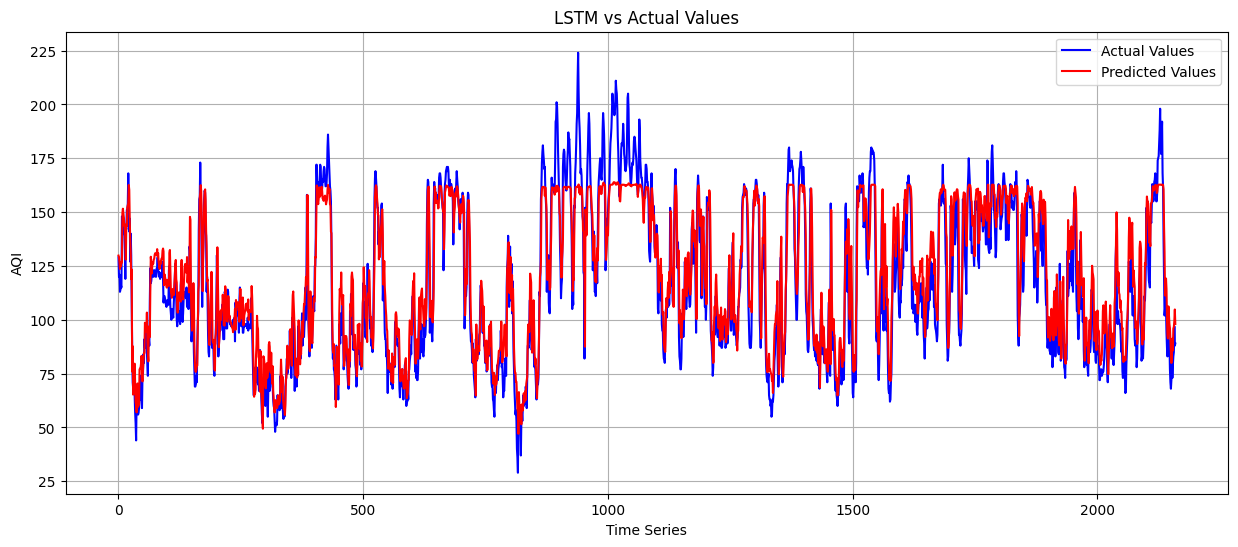

In [ ]:
plt.figure(figsize=(15, 6))
plt.ylabel('AQI')
plt.xlabel('Time Series')
plt.plot(y_test, label='Actual Values', color='b')
plt.plot(y_pred, label='Predicted Values', color='r')
plt.legend()
plt.grid()
plt.title('LSTM vs Actual Values')
plt.show()

In [ ]:
n_hours = 24 * 35
predictions = []

latest_hours = X_test[-1]

avg_predictions_LSTM = []
for i in range(n_hours):
    prediction = model_LSTM.predict(latest_hours.reshape(1, latest_hours.shape[0], latest_hours.shape[1])).flatten()
    predictions.append(prediction[0])

    latest_hours = np.roll(latest_hours, -1, axis=0)
    latest_hours[-1, -1] = prediction[0]
    if (i % 24 == 0):
        avg_predictions_LSTM.append(np.mean(predictions))
        predictions = []

print(avg_predictions_LSTM)
#print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

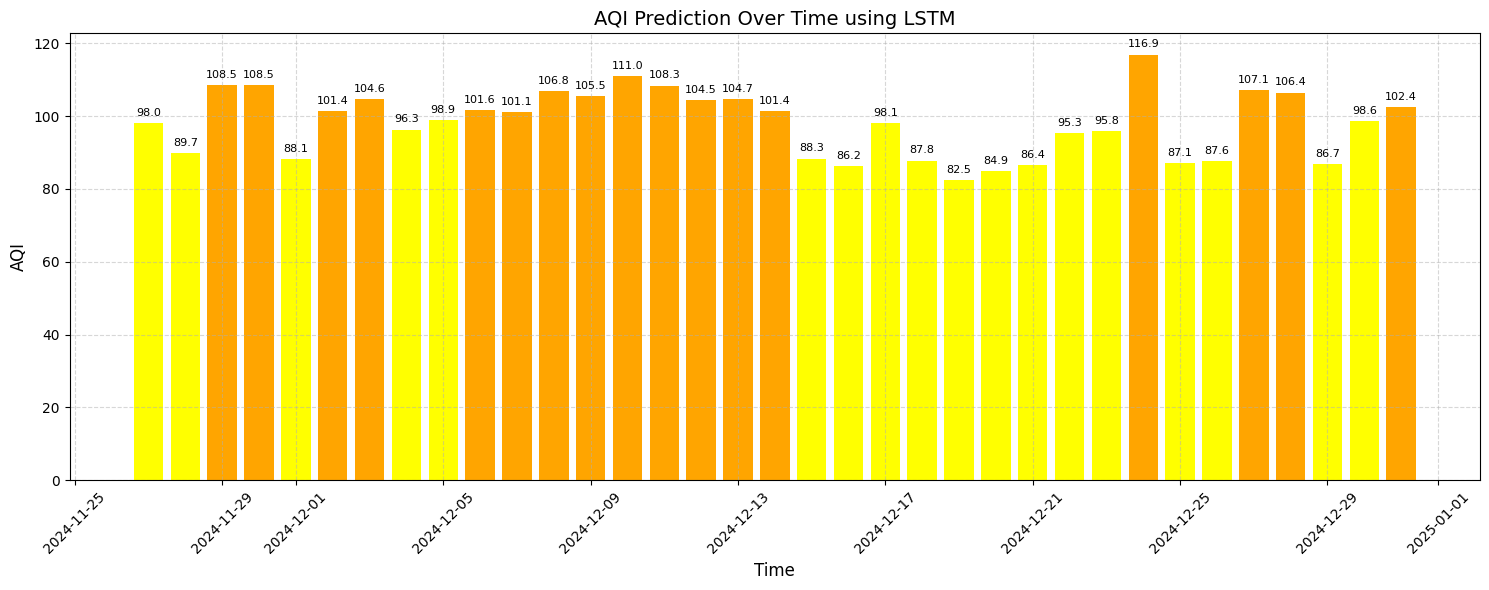

In [ ]:
colors = []
for AQI_value in avg_predictions_LSTM:
  if AQI_value <= 50:
    colors.append('green')
  elif AQI_value <= 100:
    colors.append('yellow')
  elif AQI_value <= 150:
    colors.append('orange')
  elif AQI_value <= 200:
    colors.append('red')
  else:
    colors.append('purple')
date = pd.date_range('2024-11-27',' 2024-12-31', freq='1d')
plt.figure(figsize=(15, 6))
plt.bar(date, avg_predictions_LSTM, label='Predicted AQI',color=colors)
for i, value in enumerate(avg_predictions_LSTM):
   plt.text(date[i], value + 2, f'{value:.1f}', ha='center', fontsize=8)

plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.title('AQI Prediction Over Time using LSTM', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **CNN**

In [ ]:
model1 = Sequential()
model1.add(Conv1D(64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Conv1D(8, kernel_size=2))
model1.add(Conv1D(16, kernel_size=2))
model1.add(Flatten())
model1.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=optimizer)
training = model1.fit(X_train, y_train, epochs=100, batch_size=64, shuffle=True, verbose=2)
y_prediction = model1.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
59/59 - 5s - 80ms/step - loss: 60349.0742
Epoch 2/100
59/59 - 6s - 110ms/step - loss: 2724.0161
Epoch 3/100
59/59 - 3s - 47ms/step - loss: 1861.2555
Epoch 4/100
59/59 - 2s - 42ms/step - loss: 1462.2252
Epoch 5/100
59/59 - 2s - 42ms/step - loss: 1215.2095
Epoch 6/100
59/59 - 3s - 43ms/step - loss: 1045.2823
Epoch 7/100
59/59 - 4s - 64ms/step - loss: 925.4664
Epoch 8/100
59/59 - 4s - 67ms/step - loss: 837.9164
Epoch 9/100
59/59 - 3s - 43ms/step - loss: 772.1222
Epoch 10/100
59/59 - 3s - 44ms/step - loss: 721.0078
Epoch 11/100
59/59 - 7s - 111ms/step - loss: 679.1001
Epoch 12/100
59/59 - 2s - 42ms/step - loss: 642.8306
Epoch 13/100
59/59 - 2s - 42ms/step - loss: 610.3235
Epoch 14/100
59/59 - 3s - 44ms/step - loss: 580.8777
Epoch 15/100
59/59 - 3s - 51ms/step - loss: 554.0298
Epoch 16/100
59/59 - 4s - 70ms/step - loss: 529.2886
Epoch 17/100
59/59 - 3s - 46ms/step - loss: 506.1868
Epoch 18/100
59/59 - 5s - 89ms/step - loss: 484.3836
Epoch 19/100
59/59 - 3s - 44ms/step - loss: 46

In [ ]:
print(mean_squared_error(y_test, y_prediction))
print(mean_absolute_error(y_test, y_prediction))
print(root_mean_squared_error(y_test, y_prediction))
print(mean_absolute_percentage_error(y_test, y_prediction))

732.9759926803308
22.156480692051076
27.07352937243925
0.19319141610652607


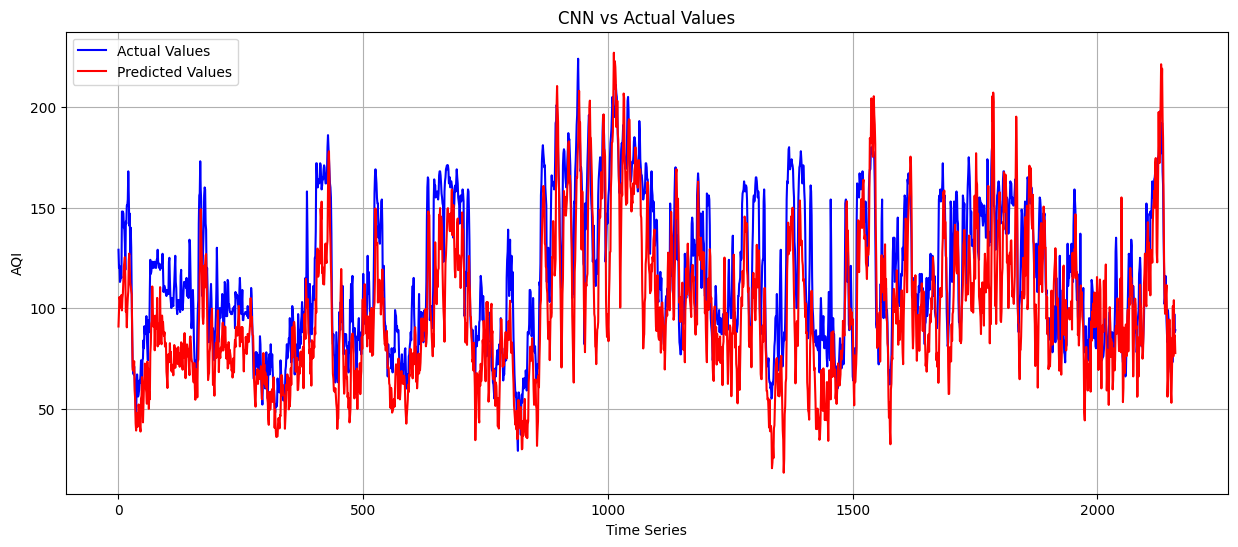

In [ ]:
plt.figure(figsize=(15, 6))
plt.ylabel('AQI')
plt.xlabel('Time Series')
plt.plot(y_test, label='Actual Values', color='b')
plt.plot(y_prediction, label='Predicted Values', color='r')
plt.legend()
plt.grid()
plt.title('CNN vs Actual Values')
plt.show()

In [ ]:
n_hours = 24 * 35
predictions = []

latest_hours = X_test[-1]

avg_predictions_CNN = []
for i in range(n_hours):
    prediction = model1.predict(latest_hours.reshape(1, latest_hours.shape[0], latest_hours.shape[1])).flatten()
    predictions.append(prediction[0])

    latest_hours = np.roll(latest_hours, -1, axis=0)
    latest_hours[-1, -1] = prediction[0]

    if (i % 24 == 0):
        avg_predictions_CNN.append(np.mean(predictions))
        predictions = []


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

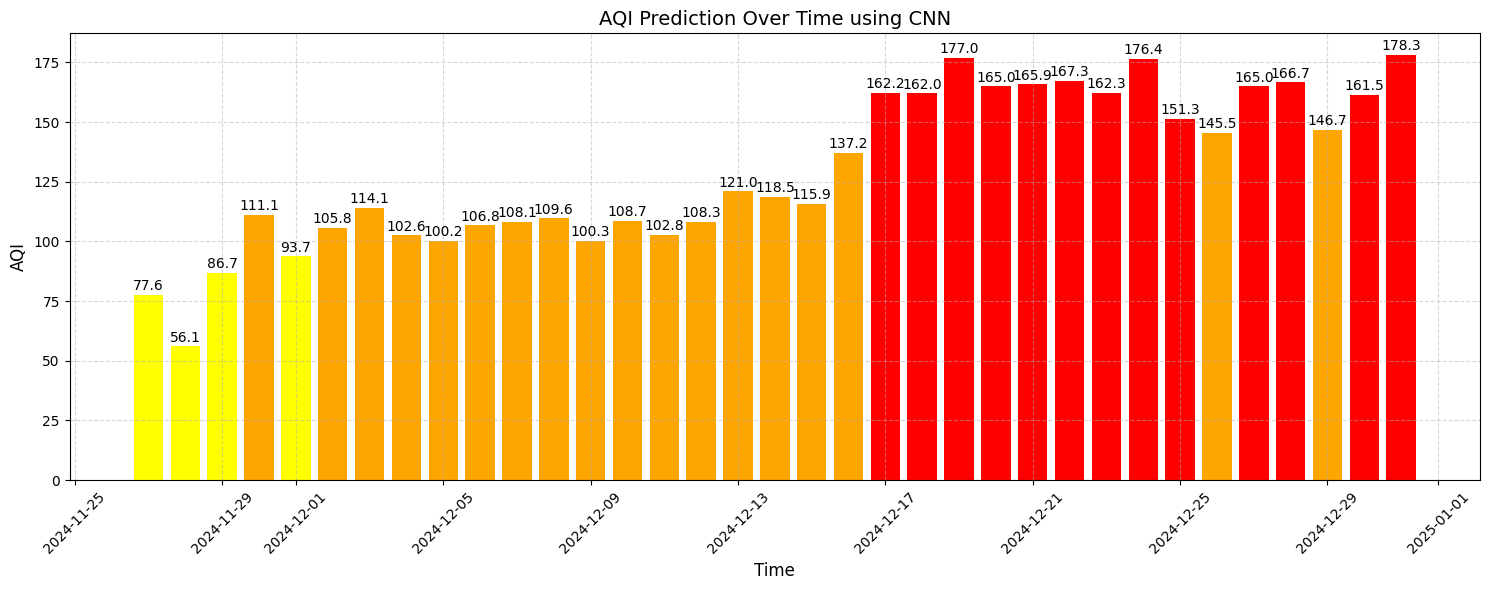

In [ ]:
colors = []
for AQI_value in avg_predictions_CNN:
  if AQI_value <= 50:
    colors.append('green')
  elif AQI_value <= 100:
    colors.append('yellow')
  elif AQI_value <= 150:
    colors.append('orange')
  elif AQI_value <= 200:
    colors.append('red')
  else:
    colors.append('purple')
date = pd.date_range('2024-11-27','2024-12-31', freq='1d')
plt.figure(figsize=(15, 6))
plt.bar(date, avg_predictions_CNN, label='Predicted AQI', color=colors)

for i, value in enumerate(avg_predictions_CNN):
    plt.text(date[i], value + 2, f'{value:.1f}', ha='center', fontsize=10)

plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.title('AQI Prediction Over Time using CNN', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
model_CNN_LSTM = Sequential([
    Conv1D(64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(8, kernel_size=2),
    Conv1D(16, kernel_size=2),
    Dropout(0.2),
    LSTM(16, return_sequences=False),
    Dense(8),
    Dense(1)
])
optimizer = Adam(learning_rate=0.001)
model_CNN_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
#X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, X_train.shape[2])
model_CNN_LSTM.fit(X_train, y_train, epochs=50, batch_size=100, shuffle=True, verbose=2)
y_pre = model_CNN_LSTM.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
38/38 - 21s - 559ms/step - loss: 8804.6963
Epoch 2/50
38/38 - 20s - 539ms/step - loss: 8488.4951
Epoch 3/50
38/38 - 20s - 537ms/step - loss: 8129.1426
Epoch 4/50
38/38 - 14s - 377ms/step - loss: 7671.7925
Epoch 5/50
38/38 - 20s - 534ms/step - loss: 7138.0078
Epoch 6/50
38/38 - 21s - 564ms/step - loss: 6449.1602
Epoch 7/50
38/38 - 20s - 517ms/step - loss: 5788.3159
Epoch 8/50
38/38 - 21s - 545ms/step - loss: 5135.0996
Epoch 9/50
38/38 - 20s - 525ms/step - loss: 4495.6650
Epoch 10/50
38/38 - 20s - 519ms/step - loss: 3884.6365
Epoch 11/50
38/38 - 22s - 587ms/step - loss: 3322.8462
Epoch 12/50
38/38 - 20s - 521ms/step - loss: 2819.4001
Epoch 13/50
38/38 - 20s - 530ms/step - loss: 2383.9436
Epoch 14/50
38/38 - 13s - 346ms/step - loss: 2019.7473
Epoch 15/50
38/38 - 22s - 570ms/step - loss: 1675.5685
Epoch 16/50
38/38 - 19s - 509ms/step - loss: 1387.6152
Epoch 17/50
38/38 - 14s - 375ms/step - loss: 1225.0894
Epoch 18/50
38/38 - 21s - 543ms/step - loss: 1125.7646
Epoch 19/50
38/38 -

In [ ]:
n_hours = 24 * 35
predictions = []

latest_hours = X_test[-1]

avg_predictions_CNN_LSTM = []
for i in range(n_hours):
    prediction = model_CNN_LSTM.predict(latest_hours.reshape(1, latest_hours.shape[0], latest_hours.shape[1])).flatten()
    predictions.append(prediction[0])

    latest_hours = np.roll(latest_hours, -1, axis=0)
    latest_hours[-1, -1] = prediction[0]

    if (i % 24 == 0):
        avg_predictions_CNN_LSTM.append(np.mean(predictions))
        predictions = []

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

In [ ]:
print(avg_predictions_CNN_LSTM)

[88.81036, 88.87225, 88.81036, 89.271996, 88.88174, 88.87262, 88.81036, 88.81036, 88.81036, 88.87225, 88.81036, 89.15066, 89.0163, 89.08915, 89.2222, 88.97119, 88.81036, 89.138794, 89.23489, 89.22351, 88.81036, 88.87225, 88.81036, 88.94363, 88.81036, 88.81036, 88.81036, 88.87225, 88.95441, 88.87225, 88.81036, 89.271996, 88.88174, 88.87262, 88.81036]
